# Image segmentation 

_In the [quickstart section](./quickstart.ipynb), you saw a short example of how to train an image segmentation model. In this tutorial, we'll recreate that using the mid-level APIs._

In [45]:
using FastAI, Metalhead
import CairoMakie; CairoMakie.activate!(type="png")

In image segmentation, instead of assigning a class to a whole image as in [image classification](../methods/imageclassification.md), we want to classify each pixel of an image. We'll use the CamVid dataset which contains street images with every pixel annotated as one of 32 classes.

Inside the dataset folder, we find `images/`, a subfolder with all the input images, `labels/`, a subfolder containing the segmentation masks (saved as images) and `codes.txt` which contains the class names:

In [2]:
dir = datasetpath("camvid_tiny")
readdir(dir)

3-element Vector{String}:
 "codes.txt"
 "images"
 "labels"

Every line in `codes.txt` corresponds to one class, so let's load it:

In [3]:
classes = readlines(open(joinpath(dir, "codes.txt")))

32-element Vector{String}:
 "Animal"
 "Archway"
 "Bicyclist"
 "Bridge"
 "Building"
 "Car"
 "CartLuggagePram"
 "Child"
 "Column_Pole"
 "Fence"
 "LaneMkgsDriv"
 "LaneMkgsNonDriv"
 "Misc_Text"
 ⋮
 "SignSymbol"
 "Sky"
 "SUVPickupTruck"
 "TrafficCone"
 "TrafficLight"
 "Train"
 "Tree"
 "Truck_Bus"
 "Tunnel"
 "VegetationMisc"
 "Void"
 "Wall"

To create our data containers we'll use [`loadfolderdata`](#), which creates data containers from folder contents. The function `loadfn` is applied to the file paths and we use `loadfile` to `loadmask` to get images and masks.

In [4]:
images = Datasets.loadfolderdata(
    joinpath(dir, "images"),
    filterfn=isimagefile,
    loadfn=loadfile)

masks = Datasets.loadfolderdata(
    joinpath(dir, "labels"),
    filterfn=isimagefile,
    loadfn=f -> loadmask(f, classes))

data = (images, masks)

(mapobs(loadfile, ["/home/lorenz/.julia/datadeps/fastai-camvid_tiny/camvid_tiny/images/0001TP_0067…]), mapobs(#1, ["/home/lorenz/.julia/datadeps/fastai-camvid_tiny/camvid_tiny/labels/0001TP_0067…]))

Now we can get an observation:

In [5]:
image, mask = sample = getobs(data, 1);

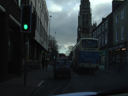

In [6]:
image

Each mask is an array with elements the same type as our classes (here `String`), but efficiently stored using integers under the hood.

In [7]:
view(mask, 50:55, 50:55)

6×6 view(::IndirectArrays.IndirectArray{String, 2, Base.ReinterpretArray{UInt8, 2, ColorTypes.Gray{FixedPointNumbers.N0f8}, PermutedDimsArray{ColorTypes.Gray{FixedPointNumbers.N0f8}, 2, (2, 1), (2, 1), Matrix{ColorTypes.Gray{FixedPointNumbers.N0f8}}}, false}, Vector{String}}, 50:55, 50:55) with eltype String:
 "Tree"       "Tree"       "Tree"  "Tree"  "Tree"  "Column_Pole"
 "Tree"       "Tree"       "Tree"  "Tree"  "Tree"  "Tree"
 "Tree"       "Tree"       "Tree"  "Tree"  "Tree"  "Column_Pole"
 "Misc_Text"  "Tree"       "Tree"  "Tree"  "Tree"  "Tree"
 "Misc_Text"  "Tree"       "Tree"  "Tree"  "Tree"  "Column_Pole"
 "Misc_Text"  "Misc_Text"  "Tree"  "Tree"  "Tree"  "TrafficLight"

Next we need to create a learning method for image segmentation. This means using images to predict masks, so we'll use the [`Image`](#) and [`Mask`](#) blocks as input and target. Since the dataset is 2D, we'll use 2-dimensional blocks.

In [38]:
method = BlockMethod(
    (Image{2}(), Mask{2}(classes)),
    (
        ProjectiveTransforms((128, 128)),
        ImagePreprocessing(),
        OneHot()
    )
)

BlockMethod(Image{2} -> Mask{2, String})

The encodings passed in transform samples into formats suitable as inputs and outputs for a model, and also allow decoding model outputs to get back to our target format: an array of class labels for every pixel.

Let's check that samples from the created data container conform to the blocks of the learning method:

In [46]:
checkblock(method.blocks, sample)

true

We can ascertain the encodings work as expected by creating a batch of encoded data and visualizing it. Here the segmentation masks are color-coded and overlayed on top of the image.

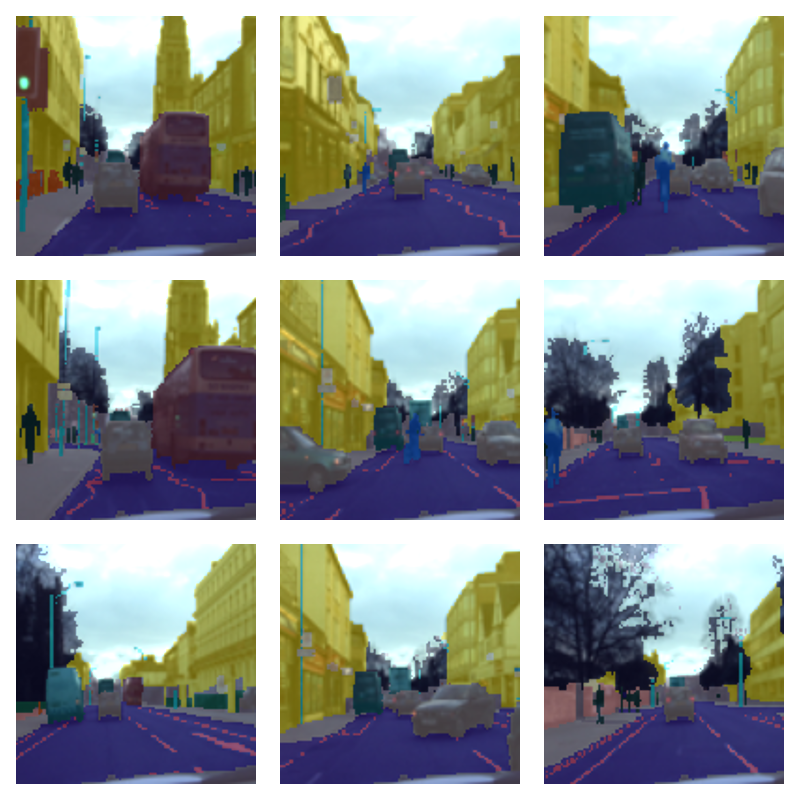

In [49]:
xs, ys = makebatch(method, data, 1:9)
plotbatch(method, xs, ys)

We can use [`describemethod`](#) to get more information about learning methods created through the data block API. We see which representations our data goes through and which encodings transform which parts.

In [48]:
describemethod(method)

#### `LearningMethod` summary

  * Task: `Image{2} -> Mask{2, String}`
  * Model blocks: `FastAI.ImageTensor{2} -> FastAI.OneHotTensor{2, String}`

Encoding a sample (`encode(method, context, sample)`)


|               Encoding |              Name |          `method.blocks[1]` |                   `method.blocks[2]` |
| ----------------------:| -----------------:| ---------------------------:| ------------------------------------:|
|                        | `(input, target)` |                  `Image{2}` |                    `Mask{2, String}` |
| `ProjectiveTransforms` |                   |              **`Image{2}`** |                **`Mask{2, String}`** |
|   `ImagePreprocessing` |                   | **`FastAI.ImageTensor{2}`** |                    `Mask{2, String}` |
|               `OneHot` |          `(x, y)` |     `FastAI.ImageTensor{2}` | **`FastAI.OneHotTensor{2, String}`** |


Decoding a model output (`decode(method, context, ŷ)`)


|               Decoding |          Name |             `method.outputblock` |
| ----------------------:| -------------:| --------------------------------:|
|                        |          `ŷ` | `FastAI.OneHotTensor{2, String}` |
|               `OneHot` |               |            **`Mask{2, String}`** |
|   `ImagePreprocessing` |               |                `Mask{2, String}` |
| `ProjectiveTransforms` | `target_pred` |                `Mask{2, String}` |


With a `method` and a matching data container, the only thing we need before we can create a `Learner` is a backbone architecture to build the segmentation model from. We'll use a pretrained model from Metalhead.jl (see the [setup instructions](../setup.md)), but you can use any convolutional architecture.
We'll use [`methodmodel`](#) to construct the model from the backbone. Since we want mask outputs, the intermediate feature representation needs to be scaled back up. Based on the `Block`s we built our method from, `methodmodel` knows that it needs to build a mapping `ImageTensor{2} -> OneHotTensor{2}` and constructs a U-Net model.

In [74]:
using Metalhead
backbone = Metalhead.ResNet50(pretrain=true).layers[1][1:end-1]
model = methodmodel(method, backbone);

In a similar vein, [`methodlossfn`](#) creates a loss function suitable for comparing model outputs and encoded targets.

In [75]:
lossfn = methodlossfn(method)

segmentationloss (generic function with 1 method)

Next we turn our data container into training and validation data loaders that will iterate over batches of encoded data and construct a `Learner`.

In [76]:
traindl, validdl = methoddataloaders(data, method, 16)
optimizer = ADAM()
learner = Learner(model, (traindl, validdl), optimizer, lossfn, ToGPU())

Learner()

Note that we could also have used [`methodlearner`](#) which is a shorthand that calls `methoddataloaders` and `methodmodel` for us.

Now let's finetune the model:

In [77]:
fitonecycle!(learner, 10, 0.033)

Epoch 1 TrainingPhase(): 100%|██████████████████████████| Time: 0:00:01


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   1.0 │ 3.51932 │
└───────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   1.0 │ 597.605 │
└─────────────────┴───────┴─────────┘


Epoch 2 TrainingPhase(): 100%|██████████████████████████| Time: 0:00:00


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   2.0 │ 3.11025 │
└───────────────┴───────┴─────────┘
┌─────────────────┬───────┬───────────┐
│           Phase │ Epoch │      Loss │
├─────────────────┼───────┼───────────┤
│ ValidationPhase │   2.0 │ 5.43198e8 │
└─────────────────┴───────┴───────────┘


Epoch 3 TrainingPhase(): 100%|██████████████████████████| Time: 0:00:00


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   3.0 │ 2.58655 │
└───────────────┴───────┴─────────┘
┌─────────────────┬───────┬──────────┐
│           Phase │ Epoch │     Loss │
├─────────────────┼───────┼──────────┤
│ ValidationPhase │   3.0 │ 2.2565e6 │
└─────────────────┴───────┴──────────┘


Epoch 4 TrainingPhase(): 100%|██████████████████████████| Time: 0:00:00


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   4.0 │ 2.23363 │
└───────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   4.0 │ 1635.12 │
└─────────────────┴───────┴─────────┘


Epoch 5 TrainingPhase(): 100%|██████████████████████████| Time: 0:00:00


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   5.0 │ 1.96915 │
└───────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   5.0 │ 13.3396 │
└─────────────────┴───────┴─────────┘


Epoch 6 TrainingPhase(): 100%|██████████████████████████| Time: 0:00:00


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   6.0 │ 1.79812 │
└───────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   6.0 │ 2.12668 │
└─────────────────┴───────┴─────────┘


Epoch 7 TrainingPhase(): 100%|██████████████████████████| Time: 0:00:00


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   7.0 │ 1.69114 │
└───────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   7.0 │ 1.64352 │
└─────────────────┴───────┴─────────┘


Epoch 8 TrainingPhase(): 100%|██████████████████████████| Time: 0:00:00


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   8.0 │ 1.62148 │
└───────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   8.0 │ 1.51248 │
└─────────────────┴───────┴─────────┘


Epoch 9 TrainingPhase(): 100%|██████████████████████████| Time: 0:00:00


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   9.0 │ 1.58367 │
└───────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   9.0 │ 1.49466 │
└─────────────────┴───────┴─────────┘


Epoch 10 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:00


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │  10.0 │ 1.58195 │
└───────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │  10.0 │ 1.50358 │
└─────────────────┴───────┴─────────┘


And look at the results on a batch of validation data:

In [78]:
xs, ys = first(learner.data.validation);
ŷs = learner.model(gpu(xs)) |> cpu;

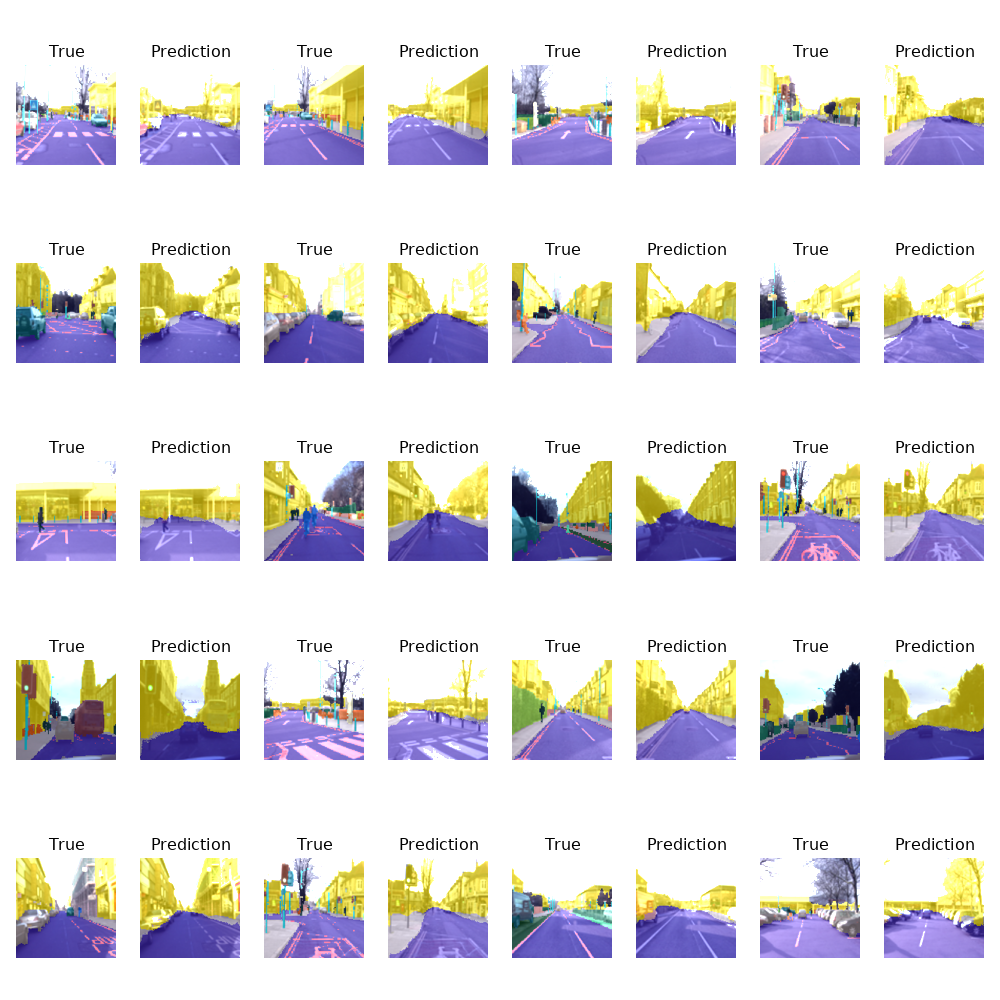

In [79]:
FastAI.plotpredictions!(CairoMakie.Figure(resolution=(1000, 1000)), method, xs, ŷs, ys)

Not bad for only 100 images of training data!

---

The data block API can also be used for 3D segmentation, but the tutorial for that is still in the works.